# Birds' Bones and Living Habits

## 1. Import necessary libraries and dataset.

Import necessary libraries.

In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from itertools import cycle, islice
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

%matplotlib inline


Import dataset from Kaggle: https://www.kaggle.com/zhangjuefei/birds-bones-and-living-habits#bird.csv

In [4]:
data = pd.read_csv('./bird.csv')

## 2. Explore the dataset.

Descriptive statistics for entire dataset.

In [147]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,420.0,209.500000,121.387808,0.00,104.7500,209.500,314.250,419.00
huml,419.0,64.650501,53.834549,9.85,25.1700,44.180,90.310,420.00
humw,419.0,4.370573,2.854617,1.14,2.1900,3.500,5.810,17.84
ulnal,417.0,69.115372,58.784775,14.09,28.0500,43.710,97.520,422.00
ulnaw,418.0,3.597249,2.186747,1.00,1.8700,2.945,4.770,12.00
feml,418.0,36.872416,19.979082,11.83,21.2975,31.130,47.120,117.07
femw,419.0,3.220883,2.023581,0.93,1.7150,2.520,4.135,11.64
tibl,418.0,64.662823,37.838145,5.50,36.4175,52.120,82.870,240.00
tibw,419.0,3.182339,2.080827,0.87,1.5650,2.490,4.255,11.03
tarl,419.0,39.229976,23.184313,7.77,23.0350,31.740,50.250,175.00


Make a list of the six living habit types included in this dataset.

In [148]:
types = set(data['type'].values)
print (types)

{'P', 'SO', 'T', 'R', 'SW', 'W'}


## 3. Clean and prepare data.

Delete 'id' column as it is not necessary for this analysis.

In [156]:
del data['id']

Remove any null values.

In [157]:
data = data.dropna()

Add columns for width:length index for all bones.

In [189]:
data['hum_index'] = data['humw']/data['huml']
data['ulna_index'] = data['ulnaw']/data['ulnal']
data['fem_index'] = data['femw']/data['feml']
data['tib_index'] = data['tibw']/data['tibl']
data['tar_index'] = data['tarw']/data['tarl']

data['hum_fem'] = data['huml']/data['feml']
data['hum_tib'] = data['huml']/data['tibl']
data['hum_tar'] = data['huml']/data['tarl']
data['ulna_fem'] = data['ulnal']/data['feml']
data['ulna_tib'] = data['ulnal']/data['tibl']
data['ulna_tar'] = data['ulnal']/data['tarl']

In [191]:
data[index_features].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hum_index,413.0,0.078014,0.023098,0.037277,0.061086,0.077459,0.091612,0.292386
ulna_index,413.0,0.061532,0.024796,0.027773,0.047200,0.060057,0.068981,0.262145
fem_index,413.0,0.085091,0.015206,0.043128,0.075901,0.081164,0.089762,0.157209
tib_index,413.0,0.049290,0.034923,0.027465,0.041112,0.046540,0.052604,0.732727
tar_index,413.0,0.079120,0.058976,0.033450,0.052028,0.062438,0.081633,0.476677


In [192]:
data[wl_features].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hum_fem,413.0,1.644358,0.757477,0.605409,1.056916,1.363794,2.173203,4.066365
hum_tib,413.0,0.961209,0.787394,0.464842,0.629637,0.852339,1.061913,14.687273
hum_tar,413.0,1.648773,1.235471,0.552430,0.931733,1.355155,1.975273,9.631148
ulna_fem,413.0,1.763679,0.793245,0.584916,1.246978,1.490650,2.242991,5.349637
ulna_tib,413.0,1.040077,0.773804,0.355961,0.715020,0.894975,1.140948,13.092727
ulna_tar,413.0,1.798955,1.592913,0.599478,1.069340,1.478671,1.927674,13.944223


Below are lists of features that will be used for clustering and classification analysis.

In [190]:
raw_features = ['huml', 'humw', 'ulnal', 'ulnaw', 'feml', 'femw', 'tibl', 'tibw',
       'tarl', 'tarw']
length_features = ['huml', 'ulnal', 'feml', 'tibl', 'tarl']
index_features = ['hum_index', 'ulna_index', 'fem_index', 'tib_index', 'tar_index']

wl_features = ['hum_fem', 'hum_tib', 'hum_tar', 'ulna_fem', 'ulna_tib', 'ulna_tar']

## 4. Analyze data by clustering.

Which bone measurements are most useful in differentiating clusters?

Select features of interest for clustering.

In [193]:
data_raw = data[raw_features]
data_length = data[length_features]
data_index = data[index_features]
data_wl = data[wl_features]

Define functions for k-Means Clustering.

In [247]:
def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')

	Z = [np.append(A, index) for index, A in enumerate(centers)]

	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P

def parallel_plot(data):
    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k', 'c']), None, len(data)))
    plt.figure(figsize=(15,8))
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')
    plt.ylabel('Center Mean')
    plt.xlabel('Feature')

def cluster_plot(dataframe, features):
    kmeans = KMeans(n_clusters=6)
    model = kmeans.fit(dataframe)
    centers= model.cluster_centers_
    P = pd_centers(features, centers)
    parallel_plot(P)

### Clusters according to scaled length and diameter measurements.

Scale raw data using standard scaler.

In [223]:
data_raw_scaled = StandardScaler().fit_transform(data_raw)

Text(0.5, 1.0, 'Clusters According to Scaled Bone Lengths and Diameters')

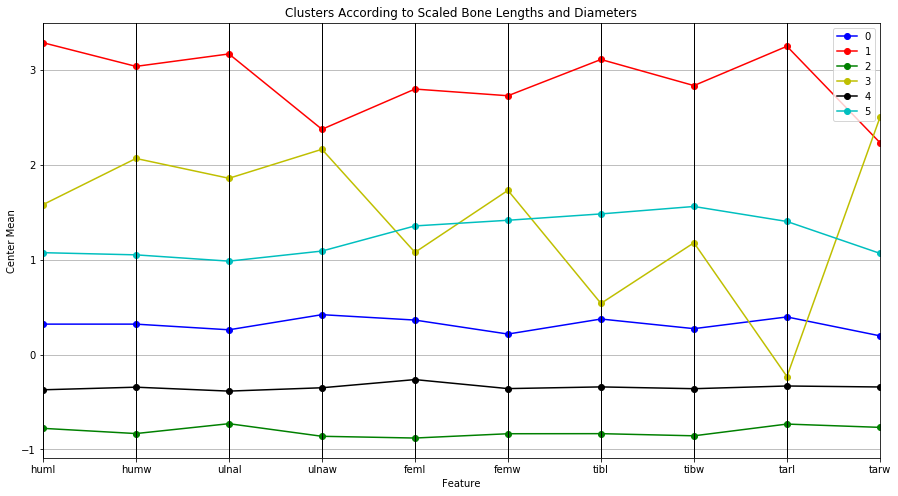

In [250]:
cluster_plot(data_raw_scaled, raw_features)
plt.title('Clusters According to Scaled Bone Lengths and Diameters')

### Clusters according to length.

Text(0.5, 1.0, 'Clusters According to Bone Lengths')

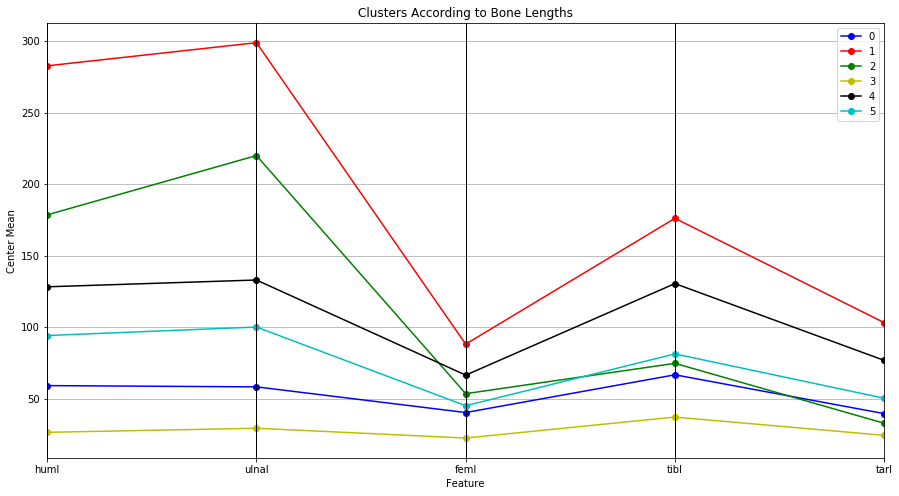

In [251]:
cluster_plot(data_length, length_features)
plt.title('Clusters According to Bone Lengths')

### Clusters according to length:width indices.

Text(0.5, 1.0, 'Clusters According to Bone Indices')

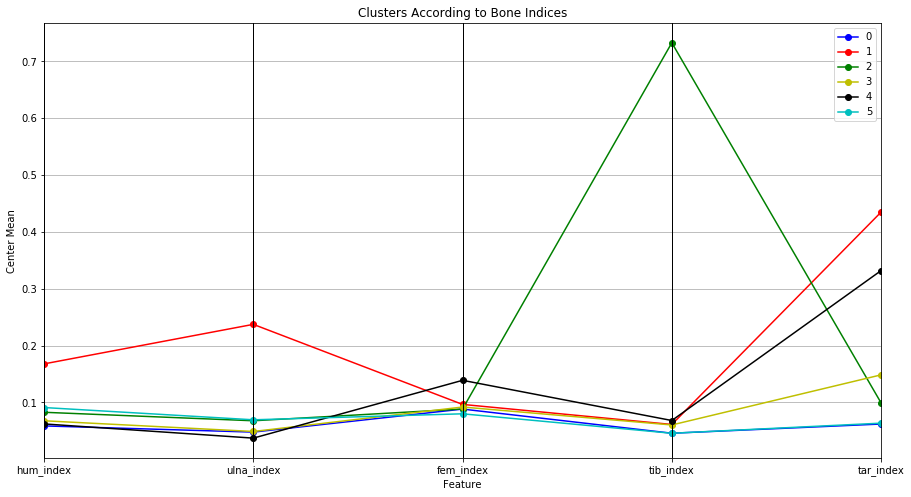

In [252]:
cluster_plot(data_index, index_features)
plt.title('Clusters According to Bone Indices')

Text(0.5, 1.0, 'Clusters According to Wing to Leg Length Ratios')

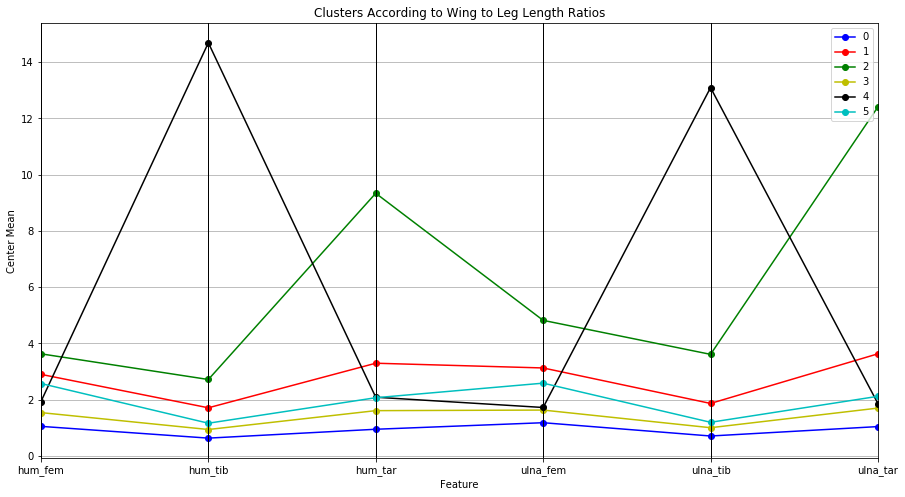

In [253]:
cluster_plot(data_wl, wl_features)
plt.title('Clusters According to Wing to Leg Length Ratios')

## 5. Analyze data by classification.

Input variables: bone measurements
<br>
Target variable: living habit (P, SO, T, R, SW, W)

In [200]:
def add_label(dataframe, item):
    data_tolabel = dataframe.copy()
    data_tolabel['type'] = data['type']
    data_tolabel[item + 'label'] = (data_tolabel.type.str.match(item))*1
    return data_tolabel

def classify_by_type(dataframe, item, features):
    y = add_label(dataframe, item)[item + 'label'].copy()
    x = add_label(dataframe, item)[features].copy()
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=324)
    type_classifier = DecisionTreeClassifier(max_leaf_nodes=10, random_state=0)
    type_classifier.fit(x_train, y_train)
    predictions = type_classifier.predict(x_test)
    return accuracy_score(y_true = y_test, y_pred = predictions)

def print_df(accuracy_scores, type_list):
    zipped = list(zip(accuracy_scores, type_list))
    zipped_df = pd.DataFrame(zipped, columns = ['Accuracy', 'Type'])
    print(zipped_df)
    

Run Decision Tree algorithm for each of the six target variables and compare accuracy scores.

### Accuracy of classification using lengths and diameters.

In [201]:
raw_accuracies = []
for item in types:
    raw_accuracies.append(classify_by_type(data, item, raw_features))
print_df(raw_accuracies, types)

   Accuracy Type
0  0.941606    P
1  0.948905   SO
2  0.956204    T
3  0.919708    R
4  0.832117   SW
5  0.868613    W


<Figure size 432x288 with 0 Axes>

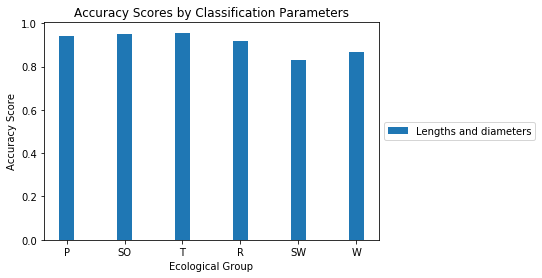

<Figure size 432x288 with 0 Axes>

In [211]:
x = np.arange(len(types))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x,raw_accuracies, width, label='Lengths and diameters')


ax.set_ylabel('Accuracy Score')
ax.set_xlabel('Ecological Group')
ax.set_title('Accuracy Scores by Classification Parameters')
ax.set_xticks(x)
ax.set_xticklabels(types)
ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))

plt.figure()

### Accuracy of classification using lengths only.

In [203]:
length_accuracies = []
for item in types:
    length_accuracies.append(classify_by_type(data, item, length_features))
print_df(length_accuracies, types)

   Accuracy Type
0  0.948905    P
1  0.948905   SO
2  0.963504    T
3  0.919708    R
4  0.802920   SW
5  0.795620    W


<Figure size 432x288 with 0 Axes>

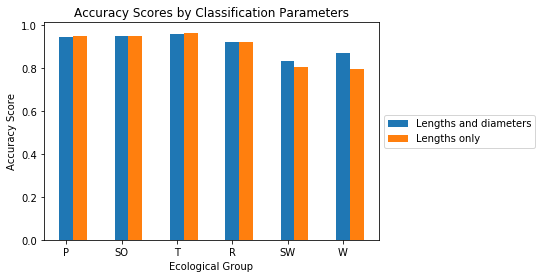

<Figure size 432x288 with 0 Axes>

In [207]:
x = np.arange(len(types))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x,raw_accuracies, width, label='Lengths and diameters')
#rects2 = ax.bar(x, index_accuracies, width, label='Bone indices')
rects3 = ax.bar(x + .25, length_accuracies, width, label='Lengths only')
#rects4 = ax.bar(x + .25, wl_accuracies, width, label='Wing to leg ratios')

ax.set_ylabel('Accuracy Score')
ax.set_xlabel('Ecological Group')
ax.set_title('Accuracy Scores by Classification Parameters')
ax.set_xticks(x)
ax.set_xticklabels(types)
ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))

plt.figure()

### Accuracy of classification using diameter:length indices.

In [202]:
index_accuracies = []
for item in types:
    index_accuracies.append(classify_by_type(data, item, index_features))
print_df(index_accuracies, types)

   Accuracy Type
0  0.912409    P
1  0.948905   SO
2  0.970803    T
3  0.875912    R
4  0.875912   SW
5  0.875912    W


<Figure size 432x288 with 0 Axes>

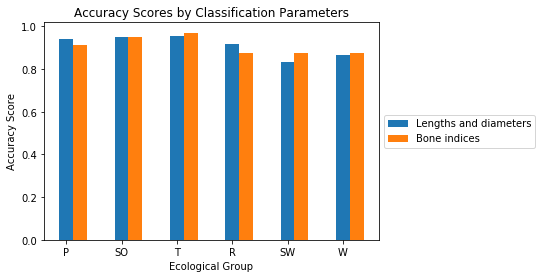

<Figure size 432x288 with 0 Axes>

In [206]:
x = np.arange(len(types))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x,raw_accuracies, width, label='Lengths and diameters')
rects2 = ax.bar(x + .25, index_accuracies, width, label='Bone indices')
#rects3 = ax.bar(x, length_accuracies, width, label='Lengths only')
#rects4 = ax.bar(x + .25, wl_accuracies, width, label='Wing to leg ratios')

ax.set_ylabel('Accuracy Score')
ax.set_xlabel('Ecological Group')
ax.set_title('Accuracy Scores by Classification Parameters')
ax.set_xticks(x)
ax.set_xticklabels(types)
ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))

plt.figure()

### Accuracy of classification using wing to leg length ratios.

In [209]:
wl_accuracies = []
for item in types:
    wl_accuracies.append(classify_by_type(data, item, wl_features))
print_df(wl_accuracies, types)

   Accuracy Type
0  0.912409    P
1  0.890511   SO
2  0.948905    T
3  0.890511    R
4  0.956204   SW
5  0.934307    W


<Figure size 432x288 with 0 Axes>

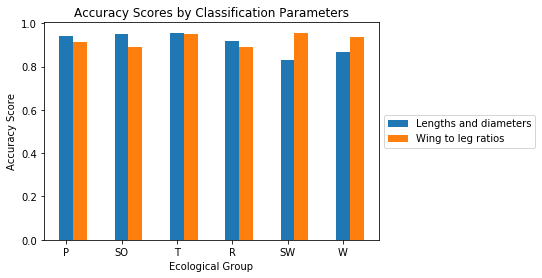

<Figure size 432x288 with 0 Axes>

In [205]:
x = np.arange(len(types))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x,raw_accuracies, width, label='Lengths and diameters')
#rects2 = ax.bar(x, index_accuracies, width, label='Bone indices')
#rects3 = ax.bar(x, length_accuracies, width, label='Lengths only')
rects4 = ax.bar(x + .25, wl_accuracies, width, label='Wing to leg ratios')

ax.set_ylabel('Accuracy Score')
ax.set_xlabel('Ecological Group')
ax.set_title('Accuracy Scores by Classification Parameters')
ax.set_xticks(x)
ax.set_xticklabels(types)
ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))

plt.figure()

### Comparison of all classification parameters.

<Figure size 432x288 with 0 Axes>

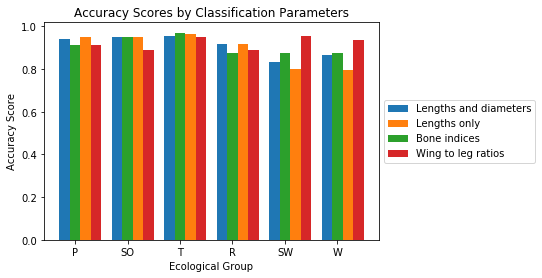

<Figure size 432x288 with 0 Axes>

In [213]:
x = np.arange(len(types))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - .2,raw_accuracies, width, label='Lengths and diameters')
rects2 = ax.bar(x + .2, length_accuracies, width, label='Lengths only')
rects3 = ax.bar(x, index_accuracies, width, label='Bone indices')
rects4 = ax.bar(x + .4, wl_accuracies, width, label='Wing to leg ratios')

ax.set_ylabel('Accuracy Score')
ax.set_xlabel('Ecological Group')
ax.set_title('Accuracy Scores by Classification Parameters')
ax.set_xticks(x)
ax.set_xticklabels(types)
ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))

plt.figure()